## Download Dataset from Kaggle

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharmilapolamuri","key":"e4f89438c4a7a4fc5630cb210de7a196"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 34% 9.00M/26.3M [00:00<00:00, 22.8MB/s]
100% 26.3M/26.3M [00:00<00:00, 59.4MB/s]
 21% 5.00M/23.4M [00:00<00:01, 17.4MB/s]
100% 23.4M/23.4M [00:00<00:00, 59.3MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 201MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 98.5MB/s]


In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=1e4b4f48a48d899d794b59994ba41d003cb518ec5bc88aff8ee81f5ae8049aa5
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [5]:
!unzip "/content/train.csv.zip" 
!unzip "/content/test_labels.csv.zip"
!unzip "/content/test.csv.zip"
!unzip "/content/sample_submission.csv.zip"

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


## Download Glove word embedding 

In [6]:
## download word embedding glove 
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-02-16 15:03:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-16 15:03:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-16 15:03:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [9]:
!unzip /content/glove.6B.zip -d "Glove"

Archive:  /content/glove.6B.zip
  inflating: Glove/glove.6B.50d.txt  
  inflating: Glove/glove.6B.100d.txt  
  inflating: Glove/glove.6B.200d.txt  
  inflating: Glove/glove.6B.300d.txt  


## Importing necessary libraries

In [87]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


## Define configuration values

In [88]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LEN = 100
MAX_VOCAB_SIZE = 20000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

## Loading glove word embedding

In [89]:
embedding_file = "/content/Glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
word2vec = {}
with open(embedding_file) as em_file:
  for line in em_file:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1], dtype='float32')
    word2vec[word] = vec

print(f"Total number of word vectors :- {len(word2vec)}")

Total number of word vectors :- 400000


## Loading text Comments

In [90]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

print(f"Shape of the train data :- {train_data.shape}")
print(f"Shape of the test data :- {test_data.shape}")
print(f"Shape of the test labesl :- {test_labels.shape}")

Shape of the train data :- (159571, 8)
Shape of the test data :- (153164, 2)
Shape of the test labesl :- (153164, 7)


In [91]:
print(f"Sample train data :- ")
train_data.head()

Sample train data :- 


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [92]:
print(f"Sample test data :- ")
test_data.head()

Sample test data :- 


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [93]:
print(f"Sample test label data :- ")
test_labels.head()

Sample test label data :- 


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [94]:
## check null values
print(f"Checking whether train data have any null values or not :- \n {train_data.isnull().sum()}")
print(f"Checking whether test data have any null values or not :- \n {test_data.isnull().sum()}")
print(f"Checking whether test labels data have any null values or not :- \n {test_labels.isnull().sum()}")

Checking whether train data have any null values or not :- 
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Checking whether test data have any null values or not :- 
 id              0
comment_text    0
dtype: int64
Checking whether test labels data have any null values or not :- 
 id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [95]:
sentences = train_data['comment_text'].values
test_sentences = test_data['comment_text'].values

print(f"Total number of Sentences in train data :- {len(sentences)} \n Total number of Sentences in test data :- {len(test_sentences)}")

target_labels = list(train_data.drop(['comment_text', 'id'], axis=1).columns)
target_data = train_data[target_labels].values
test_target_data = test_labels[target_labels].values


print(f"Target labels :- {target_labels}")

## finding maximun and minimum lengths of sentences 
len_of_sen = [len(s) for s in sentences]
max_seq_len = max(len_of_sen)
min_seq_len = min(len_of_sen)
sorted_seq = sorted(len_of_sen)
print(f"Max Seq Len :- {max_seq_len} \n Min Seq Len :- {min_seq_len}")
print(f"Median value :- {sorted_seq[len(sorted_seq)//2]}")

Total number of Sentences in train data :- 159571 
 Total number of Sentences in test data :- 153164
Target labels :- ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Max Seq Len :- 5000 
 Min Seq Len :- 6
Median value :- 205


## Tokenization

In [96]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
tokenizer.fit_on_texts(test_sentences)

## converts words to numbers 
sequences = tokenizer.texts_to_sequences(sentences)
test_sentences = tokenizer.texts_to_sequences(test_sentences)

word2index = tokenizer.word_index
print(f"Unique words of comment text :- {len(word2index)}")

## pad sequences on train data
data = pad_sequences(sequences=sequences, maxlen=MAX_SEQUENCE_LEN, padding='post')
print(f"Shape of the data after padding operation :- {data.shape}")

## pad sequences on test data
test_data = pad_sequences(sequences=test_sentences, maxlen=MAX_SEQUENCE_LEN, padding='post')
print(f"Shape of the test data after padding operation :- {test_data.shape}")

Unique words of comment text :- 394787
Shape of the data after padding operation :- (159571, 100)
Shape of the test data after padding operation :- (153164, 100)


In [97]:
## preparing embedding metrix using pretrained embedding model (Glove) and unique words of our present data
num_words = min(MAX_VOCAB_SIZE, len(word2index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, index in word2index.items():
  if index < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [98]:
embedding_matrix[:4]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [99]:
## embedding layer 
embedding_layer = Embedding(num_words, 
                            output_dim= EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LEN,
                            trainable = False
                            )

## Building Glove + CNN model for comments classification 

In [100]:
input_layer = Input(shape=(MAX_SEQUENCE_LEN,))
em_layer = embedding_layer(input_layer)
hidden_layer_1 = Conv1D(128, 3, activation='relu')(em_layer)
pooling_layer_1 = MaxPooling1D(3)(hidden_layer_1)
hidden_layer_2 = Conv1D(128, 3, activation='relu')(pooling_layer_1)
pooling_layer_2 = MaxPooling1D(3)(hidden_layer_2)
hidden_layer_3 = Conv1D(128, 3, activation='relu')(pooling_layer_2)
global_pooling_layer = GlobalMaxPooling1D()(hidden_layer_3)
dense_layer = Dense(128, activation='relu')(global_pooling_layer)
output_layer = Dense(len(target_labels), activation='sigmoid')(dense_layer)

model = Model(input_layer, output_layer)

In [101]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 128)            4928

In [102]:
## model compilation
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [103]:
## train a model
training_history = model.fit(data, 
                             target_data, 
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, 
                             validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 6s 5ms/step - loss: 0.1493 - accuracy: 0.9388 - val_loss: 0.1432 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1374 - accuracy: 0.9870 - val_loss: 0.1399 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1347 - accuracy: 0.9916 - val_loss: 0.1359 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1336 - accuracy: 0.9927 - val_loss: 0.1322 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1318 - accuracy: 0.9936 - val_loss: 0.1332 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1356 - accuracy: 0.9942 - val_loss: 0.1342 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 5s 5ms/step - loss: 0.1316 - accuracy: 0.9942 - val_loss: 0.1329 - val_accuracy: 0.9916
Epoch 

## Plot the training & validation accuracy and losses

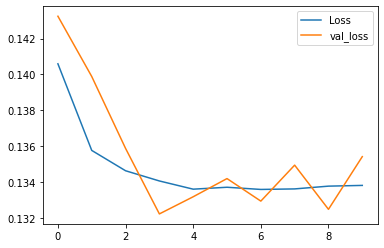

In [104]:
plt.plot(training_history.history['loss'], label='Loss')
plt.plot(training_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

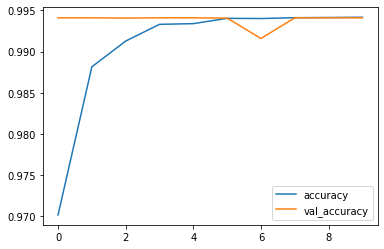

In [105]:
plt.plot(training_history.history['accuracy'], label='accuracy')
plt.plot(training_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Evaluation

In [106]:
model.evaluate(x=test_data, y=test_target_data, batch_size=BATCH_SIZE)

1197/1197 [==============================] - 3s 3ms/step - loss: -2.6408 - accuracy: 0.9990


[-2.6408169269561768, 0.9990010857582092]